In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, cross_val_score

# test file upload

In [0]:
test1_dir = '/content/drive/My Drive/merge_all_flatten_test1.csv'
test2_dir = '/content/drive/My Drive/merge_all_flatten_test2.csv'

test1 = pd.read_csv(test1_dir)
test2 = pd.read_csv(test2_dir)

# file upload

In [0]:
pledge_dir = '/content/drive/My Drive/train_pledge.csv'
label_dir = '/content/drive/My Drive/train_label_add.csv'
pay_dir = '/content/drive/My Drive/train_payment.csv'
activity_dir = '/content/drive/My Drive/train_activity.csv'
combat_dir = '/content/drive/My Drive/train_combat.csv'
trade_dir = '/content/drive/My Drive/train_trade.csv'

In [0]:
train_activity = pd.read_csv(activity_dir)
train_activity = train_activity[train_activity.server != 'bs']
train_activity = train_activity[train_activity.playtime != 0]
train_combat = pd.read_csv(combat_dir)
train_trade = pd.read_csv(trade_dir)
train_label = pd.read_csv(label_dir)
del train_label['Unnamed: 0']
train_payment = pd.read_csv(pay_dir)

In [0]:
merge_all_flatten = pd.read_csv('/content/drive/My Drive/merge_all_flatten.csv')

In [19]:
merge_all_flatten.shape

(40000, 401)

In [0]:
merge_all = pd.merge(merge_all_flatten, train_label, on = 'acc_id')

In [21]:
merge_all.shape

(40000, 405)

In [0]:
# merge_all.rename(columns = {'amount_spent_x' : 'amount_apent'}, inplace = True)
merge_all.rename(columns = {'amount_spent_x' : 'amount_spent'}, inplace = True)

# Grid search(binary)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time'], axis=1),
                                 merge_all.secession,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 401), (12000, 401), (28000,), (12000,))

In [0]:
from sklearn.model_selection import StratifiedKFold
# GridSearchCV with XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)
param_grid = {'objective':['binary:logistic'],
              'nthread':[4],
              'gamma' : [0,1],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [4,5,6,7,8],
              'min_child_weight': [10],
              'subsample': [0.8,0.9],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              "tree_method":['gpu_hist'],
                "predictor":['gpu_predictor'],
             } 

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator = xgb_model, cv=kfold, param_grid = param_grid , scoring = 'roc_auc', verbose = 20, n_jobs = 1, refit=True)
# n_jobs(default=1) : 내부적으로 멀티 프로세스를 사용하여 그리드 서치를 수행
# 만약 CPU 코어의 수가 충분하다면 n_jobs를 늘릴 수록 속도가 증가한다
grid.fit(X_train,y_train)

# param_grid의 모든 파라미터 조합에 대한 성능 결과.
# parameters : 사용된 파라미터
# mean_validation_score : 교차 검증(cross-validation) 결과의 평균값
# cv_validation_scores : 모든 교차 검증(cross-validation) 결과
print("Best Score:" + str(grid.best_score_))
# 최고 점수를 낸 파라미터 출력
print("Best Parameters: " + str(grid.best_params_))
print("Best Estimator: ", grid.best_estimator_)

best_parameters = grid.best_params_

- Best Parameters: 
            {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 1000, 'nthread': 4, 'objective': 'gpu:binary:logistic', 'predictor': 'gpu_predictor', 'subsample': 0.9, 'tree_method': 'gpu_hist'}


- Best Estimator:  
              XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='gpu:binary:logistic',
              predictor='gpu_predictor', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, tree_method='gpu_hist', verbosity=1)

In [0]:
import pickle
with open('/content/drive/My Drive/grid_model_bin.pkl', 'wb') as f:
    pickle.dump(grid, f)

In [0]:
import pickle
with open('/content/drive/My Drive/grid_model_bin.pkl', 'rb') as f:
    grid_model_bin = pickle.load(f)

[00:10:53] WARNING: /workspace/src/objective/regression_obj.cu:170: gpu:binary:logistic is now deprecated, use binary:logistic instead.


In [0]:
y_pred = np.where(grid_model_bin.predict_proba(X_test)[:,1] > 0.45, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.7819166666666667, 0.7614620362774588, 0.8014162561576355, 5206, 6496)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      6533
           1       0.78      0.73      0.75      5467

    accuracy                           0.78     12000
   macro avg       0.78      0.78      0.78     12000
weighted avg       0.78      0.78      0.78     12000



In [0]:
y_scores = grid_model_bin.predict_proba(X_test)[:,1]
p, r, thresholds = precision_recall_curve(y_test, y_scores)

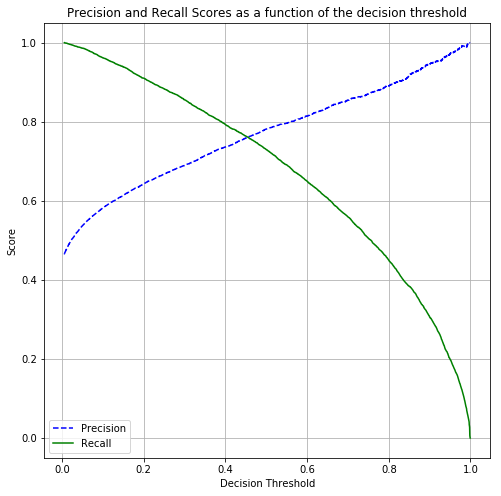

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.grid(b=True, which='both', axis='both')
    
plot_precision_recall_vs_threshold(p, r, thresholds)

     pred_neg  pred_pos
neg      4425      2108
pos       790      4677


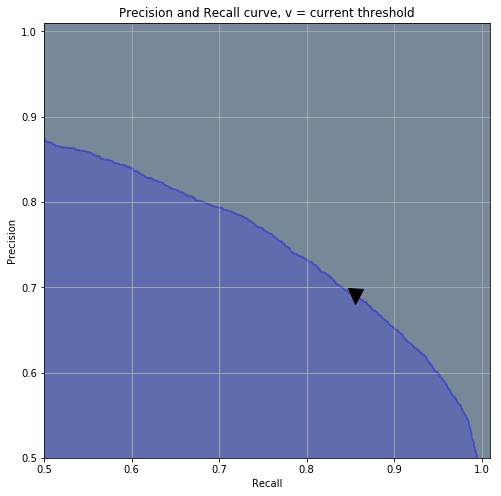

In [0]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]


def precision_recall_threshold(p, r, thresholds, t=0.5):
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
#     plt.figure(figsize=(8,8))
    fig = plt.figure(figsize=(8,8))
    ax=fig.add_subplot(1,1,1)
    plt.title("Precision and Recall curve, v = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01])
    plt.xlim([0.5, 1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], marker='v', c='k',
            markersize=15) 
    ax.set_facecolor('lightslategray')

    
precision_recall_threshold(p, r, thresholds, 0.3)

## grid search 결과 onevsrest 돌려보기

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all.drop(['acc_id',
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time'], axis=1),
                                 merge_all.secession,
                                 test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

np.random.seed(42)

eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='binary:logistic',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 10,
              min_child_weight= 10,
              subsample= 0.9,
              n_estimators= 1000,
              tree_method='gpu_hist',
               predictor='gpu_predictor', eval_set = eval_set))


# You may need to use MultiLabelBinarizer to encode your variables from arrays [[x, y, z]] to a multilabel 
# format before training.



OVR.fit(X_train, y_train)

print('One vs Rest accuracy : %f' % OVR.score(X_train, y_train))

One vs Rest accuracy : 0.999238


In [0]:
from sklearn.metrics import accuracy_score

y_pred = OVR.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

(0.7748333333333334, 0.7446124763705103)

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 1000, max_depth = 35,
                                 criterion = 'gini', random_state = 42))

                          

OVR.fit(X_train, y_train)

print('One vs Rest accuracy : %f' % OVR.score(X_train, y_train))

One vs Rest accuracy : 0.999143


In [0]:
from sklearn.metrics import accuracy_score

y_pred = OVR.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)
# 7796 7445
#7758 7387

(0.7815833333333333, 0.7478110266525546)

# 이부분에 있는 인자가 최적의 hyperparameter

max depth와 min_child weight 가 영향 큼

### grid search를 통해 나온 최적의 파라미터로 xgbclassifier 돌려보기
(max depth = 10으로 올림)

In [0]:
import xgboost as xgb

np.random.seed(42)

xg_clf = xgb.XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='binary:logistic',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 8,
              min_child_weight= 3, 
              subsample= 0.9,
              n_estimators= 1000,
                          tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,
xg_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = np.where(xg_clf.predict_proba(X_test)[:,1] > 0.45, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.78175, 0.7604061842466379, 0.7994186046511628, 5225, 6536)

## data scale 후 예측
(성능 떨어짐)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(merge_all_flatten.drop('acc_id',axis=1))
merge_all_flatten_standard = scaler.transform(merge_all_flatten.drop('acc_id', axis=1))

In [0]:
merge_standard = pd.DataFrame(merge_all_flatten_standard)
merge_standard.index = merge_all_flatten.acc_id
merge_standard.reset_index(inplace=True)
merge_standard.columns = merge_all_flatten.columns
merge_standard = pd.merge(merge_standard, train_label, on='acc_id')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_standard.drop(['acc_id', 
                                                                           'amount_spent_y',
                                                                           'total_spent',
                                                                          'secession',
                                                                          'survival_time'], axis=1),
                                                    merge_standard.secession,
                                                    test_size = 0.3, random_state=42)

In [0]:
import xgboost as xgb

np.random.seed(42)

xg_clf = xgb.XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='binary:logistic',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 8,
              min_child_weight= 3, 
              subsample= 0.9,
              n_estimators= 1000,
                          tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,
xg_clf.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = np.where(xg_clf.predict_proba(X_test)[:,1] > 0.45, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.7784166666666666, 0.7563902885936784, 0.7956349206349206, 5213, 6552)

# binary classification에 class weight을 적용한 후 64일 처내고 기존 성능과 비교
(xgboost weight 함수 종류 : sample_weight, scale_pos_weight)

positive : 1

nagative : 0

scale_pos_weignt : nag / pos

In [0]:
class_weights = get_class_weights(merge_all.secession.values)
print(class_weights)

{0: 1.0, 1: 1.22}


In [0]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


dic = get_class_weights(y_train)

w1 = np.array(y_train.map(dic))

In [0]:
import xgboost as xgb

np.random.seed(42)



xg_clf = xgb.XGBClassifier(colsample_bytree=0.7,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='binary:logistic',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 4,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, sample_weight = w1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = np.where(xg_clf.predict_proba(X_test.drop('acc_id', axis=1))[:,1] > 0.06, 1, 0)
# = predictions = [round(value) for value in y_pred]
precision = ((y_test == 0) & (y_pred == 0)).sum() / (y_pred == 0).sum()
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision, ((y_test == 0) & (y_pred == 0)).sum(),(y_pred==0).sum()

(0.5413333333333333, 0.663980463980464, 0.9733210671573137, 1058, 1087)

In [0]:
cut_df = pd.DataFrame({'acc_id': X_test['acc_id'], 'secession':y_pred})

In [0]:
cut_df[cut_df.secession == 0].shape[0], cut_df.shape[0]

(1087, 12000)

## survival time 구간화
#### 기대이익을 통해 비교한 결과 64가 아닌 1~10일의 유저를 정확하게 맞추는 것이 더우 중요하다 판단하여 이진 분류 결과를 반영하지 않고 원 데이터에서 시행

In [0]:
merge_all_sub = merge_all.copy()

# for i in cut_df[cut_df.secession == 0]['acc_id'].values:
#     merge_all_sub = merge_all_sub[merge_all_sub['acc_id'] != i]

In [24]:
merge_all_sub.shape

(40000, 405)

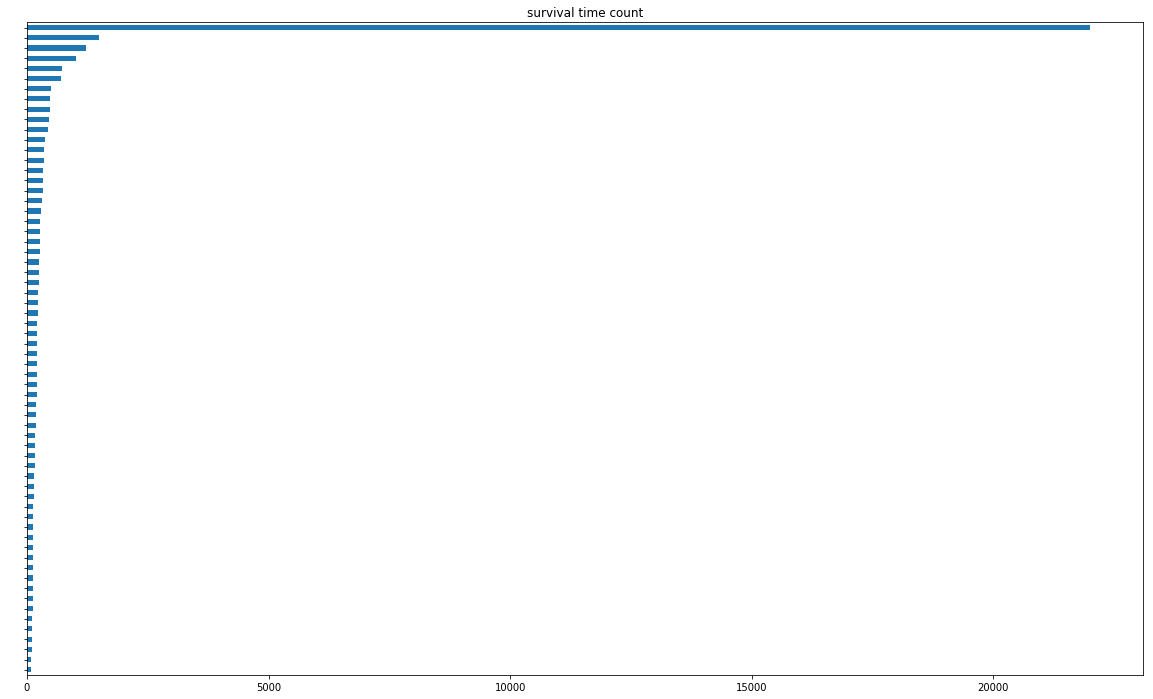

In [0]:
plt.figure(figsize = (20,12))
merge_all_sub['survival_time'].value_counts().sort_values().plot(kind='barh',title='survival time count')
plt.yticks(color = 'w')
plt.show()

In [0]:
merge_all_sub.survival_time.value_counts().sort_values()[:63].sum()/6

3000.6666666666665

첫번째구간 : 2996 x 1 = 2996

두번째구간 : 2996 X 2 = 2996 + 5982

세번째구간 : 2996 x 3 = 2996 + 5992 + 8988

In [0]:
time_freq = pd.DataFrame(merge_all_sub['survival_time'].value_counts()).reset_index()

In [0]:
time_freq.columns = ['survival_time', 'freq']

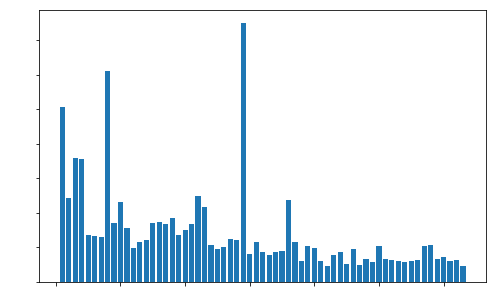

In [0]:
plt.figure(figsize = (8,5))
plt.bar(time_freq[time_freq.survival_time != 64].survival_time, time_freq[time_freq.survival_time != 64].freq)
plt.yticks(color = 'w')
plt.xticks(color = 'w')
plt.show()

In [0]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

time_freq['range'] = time_freq['survival_time'].map(dic)

In [28]:
time_freq.groupby('range').sum()

,survival_time,freq
range,,
1,78,6252
2,357,6307
3,1581,5445
4,64,21996


In [0]:
merge_all_sub['survival_term'] = merge_all_sub['survival_time'].map(dic)

In [30]:
merge_all_sub.shape

(40000, 406)

## 잔존일 기준의 survival term SMOTE

In [0]:
merge_all_sub.columns

Index(['acc_id', 'temp_cnt_x', 'private_shop', 'level_x', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt_x', 'random_defender_cnt_x',
       'same_pledge_cnt_x', 'etc_cnt_x',
       ...
       'pledge_rank_4', 'amount_spent_1', 'amount_spent_2', 'amount_spent_3',
       'amount_spent_4', 'survival_time', 'amount_spent_y', 'secession',
       'total_spent', 'survival_term'],
      dtype='object', length=406)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all_sub.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_all_sub.survival_term,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 401), (12000, 401), (28000,), (12000,))

In [32]:
# train set의 빈도
y_train.value_counts()

4    15463
2     4385
1     4301
3     3851
Name: survival_term, dtype: int64

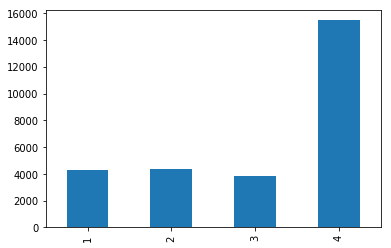

In [0]:
y_train.value_counts().sort_index().plot(kind = 'bar')

##### data sampling 구간

In [0]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)
X_smotetomek, y_smotetomek = smote_tomek.fit_resample(X_train.drop('acc_id', axis=1), y_train)

In [0]:
from imblearn.over_sampling import SMOTE

smote_s = SMOTE(random_state=42)
X_smote, y_smote = smote_s.fit_resample(X_train.drop('acc_id', axis=1), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(kind_sel = 'mode', random_state=42)
X_enn, y_enn = enn.fit_resample(X_train.drop('acc_id', axis=1), y_train)

In [0]:
from imblearn.under_sampling import TomekLinks

tomek = TomekLinks(random_state=42)
X_tomek, y_tomek = tomek.fit_resample(X_train.drop('acc_id', axis=1), y_train)

In [33]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smote_enn.fit_resample(X_train.drop('acc_id', axis=1), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
pd.Series(y_smotetomek).value_counts()

1    15031
3    14970
2    14911
4    14536
dtype: int64

In [0]:
pd.Series(y_smote).value_counts()

4    15463
3    15463
2    15463
1    15463
dtype: int64

In [0]:
pd.Series(y_enn).value_counts()

4    11013
3     3851
1     2286
2     1242
dtype: int64

In [0]:
pd.Series(y_tomek).value_counts()

4    13286
3     3851
1     3303
2     3041
dtype: int64

In [50]:
pd.Series(y_smoteenn).value_counts()

1    10990
3    10323
2    10032
4     4221
dtype: int64

In [64]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


# dic = get_class_weights(y_smoteenn)
dic = {1:2.1, 2:2.0, 3:0.1, 4:2.8}
w1 = np.array(pd.Series(y_smoteenn).map(dic))

dic

{1: 2.1, 2: 2.0, 3: 0.1, 4: 2.8}

In [65]:
import xgboost as xgb

np.random.seed(42)



xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_smoteenn,y_smoteenn, sample_weight = w1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
import pickle
with open('/content/drive/My Drive/quad_clf.pkl', 'wb') as f:
    pickle.dump(xg_clf, f)

In [66]:
y_pred = xg_clf.predict(np.array(X_test.drop('acc_id', axis=1)))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.6058333333333333, 0.6163640182577232)

0.9984623270117888
0.6670135275754423
0.6537013801756587
0.6857492729220879


(0, 8500)

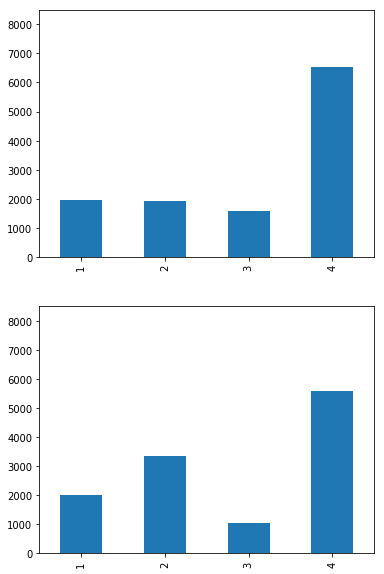

In [67]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())

fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8500])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8500])

##### 잠시 테스트

In [0]:
import pickle
with open('/content/drive/My Drive/grid_model_quad.pkl', 'wb') as f:
    pickle.dump(xg_clf, f)

In [0]:
import pickle
with open('/content/drive/My Drive/grid_model_quad.pkl', 'rb') as f:
    grid_model_quad = pickle.load(f)

In [0]:
y_pred1 = grid_model_quad.predict(np.array(test1.drop('acc_id', axis=1)))
y_pred2 = grid_model_quad.predict(np.array(test1.drop('acc_id', axis=1)))

In [0]:
test1_df = pd.DataFrame({'acc_id':test1.acc_id, 'y_pred':y_pred1})
test2_df = pd.DataFrame({'acc_id':test2.acc_id, 'y_pred':y_pred2})

In [0]:
test1_df.to_csv('/content/drive/My Drive/test1.csv', index = False)
test2_df.to_csv('/content/drive/My Drive/test2.csv', index = False)

##### 이어서 하기

In [0]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

# clf = svm.SVC

ovo = OneVsOneClassifier(SVC(C = 1, kernel = 'rbf', random_state=42))

ovo.fit(X_smotetomek,y_smotetomek)



# gamma = 'auto', 'scale'
# C = 1, 10, 100, 1000
# kernel = 'rbf'(default), 'linear', 'poly'
# verbose = 10
# random_state = 42

In [0]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = ovo.predict(X_test)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

In [0]:
# CPU version
from sklearn.svm import SVC
from sklearn import svm
import cupy as xp

X_train_arr = xp.asarray(X_smote)
y_train_arr =  xp.asarray(y_smote)

svc_clf = SVC(C = 1, kernel = 'rbf', gamma = 'auto', random_state = 42)

svc_clf.fit(X_smote, y_smote)
# svc_clf.fit(X_train_arr, y_train_arr)

In [0]:
# GPU version
import cupy as xp # gpu version
import sklearn.model_selection
from svm import SVM

svm = SVM(kernel='rbf', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_smote, y=y_smote, n_folds=5, use_optimal_lambda=True, display_plots=True)
# kernel_params의 sigma가 높을 수록 관대하게, 낮을수록 보수적

svm.fit(X_smote, y_smote)

In [0]:
from sklearn.metrics import accuracy_score, f1_score
X_test_arr = xp.asarray(X_test.drop('acc_id'))
y_test_arr = xp.asarray(y_test)
y_pred = svc_clf.predict(X_test_arr)
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 800, max_depth = 30,
                                 criterion = 'gini', random_state = 42))
# {class_label:weight}의 dic으로 class_weight 인자에 할당 가능
# balanced, balanced_subsample
                          

OVR.fit(X_smoteenn, y_somteenn)

print('One vs Rest accuracy : %f' % OVR.score(X_smoteenn, y_somteenn))

One vs Rest accuracy : 0.999747


In [0]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = OVR.predict(X_test.drop('acc_id', axis=1))
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

(0.5225, 0.557359583943764)

0.866735007688365
0.3340270551508845
0.9799247176913425
0.31363845094137455


(0, 8200)

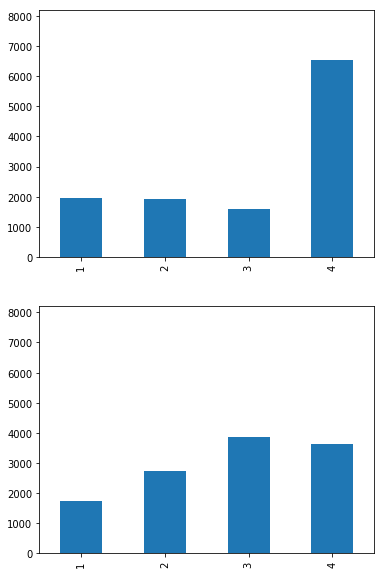

In [0]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())

fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])

##### smote 기법 별 정리 (기준 : max)
- smoteenn : accuracy(63.75), f1-sccore(61.10)
- smotetomek : accuracy(67.78), f1-score(64.58)

# feature selection

In [0]:
threshholds = ["0.6*mean", "0.9*mean"]
#["0.8*mean","0.9*mean","mean", "1.1*mean","1.2*mean", "1.3*mean" , "1.4*mean", "1.5*mean"

X_tr = X_train.drop('acc_id', axis=1)
y_tr = y_train
X_ts = X_test.drop('acc_id', axis=1)

# save list
features_index = []
features_name = []
predict_value = []
i=0

# 출력할 columns명을 확인하기 위해
aa = merge_all_flatten.drop('acc_id',axis=1)

for thresh in threshholds:
    model_ta = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')

    select_ta = SelectFromModel(model_ta, threshold=thresh)
    select_ta.fit(X_tr,y_tr)

    X_train_s1_ta = select_ta.transform(X_tr)
    X_test_s1_ta = select_ta.transform(X_ts)
  
    print("X_train_s1.shape : {}".format(X_train_s1_ta.shape))
  
    # feature name save
    feature_idx_all = select_ta.get_support()
    feature_name_all = aa[aa.columns[0:]].columns[feature_idx_all]
  
    # 값 리스트 저장
    features_index.append(feature_idx_all)
    features_name.append(feature_name_all)

X_train_s1.shape : (21000, 392)
X_train_s1.shape : (21000, 118)


feature selection 수행 결과 0.8mean이 가장 높고 그 다음이 0.9였다. 즉 시간이 더 있다면 0.7도 찍어보고, 0.8~0.9 사이값도 찍어보는 것이 좋음

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_all_sub.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_all_sub.survival_term,
                                 test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 401), (7000, 401), (12000, 401), (21000,), (7000,), (12000,))

In [0]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


dic = get_class_weights(y_test)
# dic = {1:1.8, 2:1.4, 3:1.4, 4:0.3}
w1 = np.array(y_test.map(dic))

dic

In [0]:
import xgboost as xgb

np.random.seed(42)


xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


eval_set = [(X_train[list(best_col)], y_train), (X_valid[list(best_col)], y_valid)]


xg_clf.fit(X_train[list(best_col)], y_train, eval_set = eval_set, verbose = 0)
    
y_pred = xg_clf.predict(X_test[list(best_col)])

print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'))
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())


0.6813333333333333 0.6476054869595197
0.796514607893388
0.6004162330905307
0.3212045169385194
0.058778509107607534


In [0]:
import xgboost as xgb

np.random.seed(42)

for i in range(0,2,1):
    # select한 feature df만 추출
    X_train = X_train[list(features_name[i])]
    X_valid = X_valid[list(features_name[i])]
    X_test = X_test[list(features_name[i])]

    xgb_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
              scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


    eval_set = [(X_train, y_train), (X_valid, y_valid)]


    xgb_clf.fit(X_train, y_train, eval_set = eval_set, verbose = 0)
    
    y_pred = xgb_clf.predict(X_test)

    print(accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'))
    print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
    print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
    print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
    print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())


0.6765833333333333 0.6404490985794539
0.7329574577139928
0.6004162330905307
0.33751568381430364
0.058778509107607534
0.67875 0.6461682531401011
0.7929267042542286
0.6659729448491155
0.3575909661229611
0.03933874177253942


In [0]:
# best : 0.8mean
best_col = features_name[0]

In [0]:
best_col_li = list(best_col)

In [0]:
best_col_li.insert(0, 'acc_id')

In [0]:
final_feature_df = merge_all_flatten[best_col_li]

In [0]:
final_feature_df.to_csv('/content/drive/My Drive/merge_best_feature.csv', index=False)

# best feature 기준 최적의 survival term 분류하기

In [0]:
merge_best_feature = pd.read_csv('/content/drive/My Drive/merge_best_feature.csv')

In [0]:
merge_df = pd.merge(merge_best_feature, train_label, on='acc_id')

In [8]:
merge_df.shape

(40000, 244)

In [0]:
dic = {}
for i in range(1,13):
    dic[i] = 1
    
for j in range(13,30):
    dic[j] = 2
    
for z in range(30,64):
    dic[z] = 3

dic[64] = 4

In [0]:
merge_df['survival_term'] = merge_df['survival_time'].map(dic)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merge_df.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 merge_df.survival_term,
                                 test_size = 0.3, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((28000, 240), (12000, 240), (28000,), (12000,))

In [13]:
import xgboost as xgb

np.random.seed(42)



xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 10,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# eval_set = eval_set,

xg_clf.fit(X_train.drop('acc_id', axis=1),y_train)#, sample_weight = w1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

In [0]:
print(((y_pred == 1).sum()&(y_test==1).sum()) / (y_test==1).sum())
print(((y_pred == 2).sum()&(y_test==2).sum()) / (y_test==2).sum())
print(((y_pred == 3).sum()&(y_test==3).sum()) / (y_test==3).sum())
print(((y_pred == 4).sum()&(y_test==4).sum()) / (y_test==4).sum())

fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])

In [18]:
# sample_weight에 입력 할 list 생성

# 기본 공식
# 낮은 % / 높은 % ( 둘이 합쳤을 떄 100% 기준 )

import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


dic = get_class_weights(y_test)
# dic = {1:1.8, 2:1.4, 3:1.4, 4:0.3}
w1 = np.array(y_test.map(dic))

dic

{1: 3.35, 2: 3.4, 3: 4.1, 4: 1.0}

# survival term 내 군집별 model 생성

In [0]:
survival_term1 = merge_df[(merge_df.survival_term == 1)]
survival_term2 = merge_df[(merge_df.survival_term == 2)]
survival_term3 = merge_df[(merge_df.survival_term == 3)]

In [0]:
survival_term1.shape, survival_term2.shape, survival_term3.shape

((6252, 245), (6307, 245), (5445, 245))

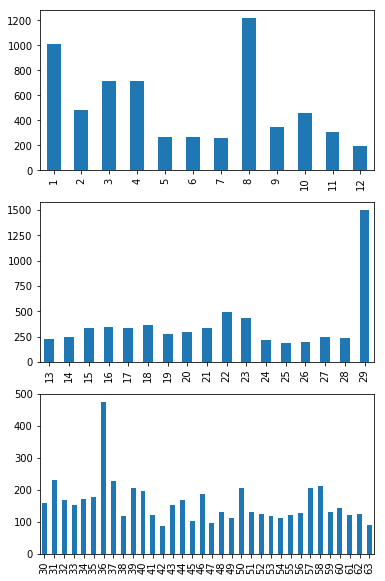

In [0]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(3,1,1)
ax1 = survival_term1.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,2)
ax2 = survival_term2.survival_time.value_counts().sort_index().plot(kind = 'bar')
# ax2.set_ylim([0,8200])
ax2 = fig.add_subplot(3,1,3)
ax2 = survival_term3.survival_time.value_counts().sort_index().plot(kind = 'bar')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survival_term1.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 survival_term1.survival_time,
                                 test_size = 0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape

((3282, 240), (3282,), (1876, 240), (1876,), (1094, 240), (1094,))

In [0]:
import xgboost as xgb

np.random.seed(42)



xg_clf = xgb.XGBClassifier(colsample_bytree=0.8,
              base_score = 0.5,
              colsample_bylevel=1,
              colsample_bynode=1,
              objective='multi:softprop',
              max_delta_step=0,
              missing=None,
              n_jobs=1,
              reg_alpha=0,
              reg_lambda=1,
#               scale_pos_weight=1,
              silent=None,
              nthread=4,
              gamma = 0,
              learning_rate= 0.05, 
              max_depth= 12,
              min_child_weight= 5, 
              subsample= 0.9,
              n_estimators= 1000,
               tree_method='gpu_hist',
               predictor='gpu_predictor')


eval_set = [(X_train.drop('acc_id', axis=1), y_train), (X_valid.drop('acc_id', axis=1), y_valid)]


xg_clf.fit(X_train.drop('acc_id', axis=1),y_train, eval_set = eval_set, verbose = 0)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
              verbosity=1)

In [0]:
y_pred = xg_clf.predict(X_test.drop('acc_id', axis=1))
# = predictions = [round(value) for value in y_pred]

accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

ValueError: ignored

In [0]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(survival_term1.drop([
                                 'amount_spent_y',
                                 'total_spent',
                                 'secession',
                                 'survival_time',
                                'survival_term'], axis=1),
                                 survival_term1.survival_time,
                                 test_size = 0.3, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4376, 401), (4376,), (1876, 401), (1876,))

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import ExtraTreesClassifier

np.random.seed(42)

# eval_set = [(X_train, y_train), (X_valid, y_valid)]

OVR = OneVsRestClassifier(ExtraTreesClassifier(n_estimators = 800, max_depth = 30,
                                 criterion = 'gini', random_state = 42))
# {class_label:weight}의 dic으로 class_weight 인자에 할당 가능
# balanced, balanced_subsample
                          

OVR.fit(X_smoteenn, y_somteenn)

print('One vs Rest accuracy : %f' % OVR.score(X_smoteenn, y_somteenn))

In [0]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = OVR.predict(X_test.drop('acc_id', axis=1))
accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')

In [0]:
fig = plt.figure(figsize = (6,10))
ax1 = fig.add_subplot(2,1,1)
ax1 = y_test.value_counts().sort_index().plot(kind = 'bar')
ax1.set_ylim([0,8200])
ax2 = fig.add_subplot(2,1,2)
ax2 = pd.Series(y_pred).value_counts().sort_index().plot(kind = 'bar')
ax2.set_ylim([0,8200])